In [140]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

### TODO:
    1. Decreasing stepsize in FW (-1 for rho/gamma)
    2. Full dataset training (deterministic FW)

In [259]:
# SMALL setting
setting_name = 'small'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, **common}],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': 0.01, 'ro': 0.6,
     'epochs': 200, **common}],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 200, **common}],
}

In [456]:
# medium setting
setting_name = 'medium_auto'
common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
     for lr in [0.1, 0.01, 0.001, 0.0001]],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 100, **common} for gamma in [-1] + list(np.linspace(0, 1, 3))
     for ro in [-1] + list(np.linspace(0, 1, 3))],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
}

In [448]:
# BIG setting
setting_name = 'big'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '50_50_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 500, **common}
     for lr in [1, 0.5, 0.1, 0.05]],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 500, **common} for gamma in [-1] + [0.1, 0.3, 0.5]
     for ro in [-1] + [0.1, 0.3, 0.5]],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 500, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
}

In [457]:
parameters = [x for group in param_groups.values() for x in group]

In [458]:
def varying_for_optim(d):
    """ What changes for optimizer? """
    d0 = d[0]
    keys = set()
    for v in d:
        for key, val in v.items():
            if d0[key] != val:
                keys.add(key)
    return list(keys)

# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['learning_rate'], 'frankwolfe': ['gamma', 'ro'], 'adam': ['learning_rate']}


In [459]:
def print_nice(y):
    if isinstance(y, float):
        return str(round(y, 10))#'%.2g' % y
    return str(y)

In [460]:
def print_one(**kwargs):
    return('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [461]:
# arguments in the correct order

f = open('experiment.py', 'r').readlines()

args_in_order = []
for l in f:
    k = 'parser.add_argument(\'--'
    if l.startswith(k):
        args_in_order.append(l[len(k):].split('\'')[0])

In [462]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(kwargs[x] if x in kwargs else None) for x in args_in_order])+'.output')

In [463]:
out = open('run_' + setting_name + '.sh', 'w')

def write_to_out(s):
    print(s)
    out.write(s + '\n')

it = 0
for params in parameters:
    if it % 4 == 0:
        write_to_out('pids=""')
    write_to_out(print_one(**params))
    #print('echo aba; sleep 3 &')
    #print('pids="$pids $!"')
    if it % 4 == 3:
        write_to_out('wait $pids')
        write_to_out('sleep 5')
    it += 1
it = len(parameters)
print('Total runs: ', it)
print('Total time: ', common['repetitions'] * 3 * it / 4)

out.close()

pids=""
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.1 --epochs 100 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 3 --architecture 20_10 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.01 --epochs 100 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 3 --architecture 20_10 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.001 --epochs 100 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 3 --architecture 20_10 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.0001 --epochs 100 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 3 --architecture 20_10 &
wait $pids
sleep 5
pids=""
python experiment.py --optimizer frankwolfe --train_batch_size 1000 --R 20.0 --gamma -1 --ro -1 --epochs 100 --image_side 5 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions

In [434]:
def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

In [435]:
def process_dict(d, do_plot = True, use_random = True):
    """ Process one dictionary from  file, return key metrics or plot them """
    d0 = d
    d = arr_of_dicts_to_dict_of_arrays(d)
    all_keys = d.keys()
    metrics = d
    #print(metrics)
    name = '0'
    
    results = {key: [] for key in all_keys}
    results['hessian_eigens_mean'] = []
    results['hessian_eigens_max'] = []
    del results['hessian_eigens']
    
    for i in range(len(d0)):
        for key, val in metrics.items():
            if key == 'hessian_eigens':
                eigens = val[i]
                results['hessian_eigens_mean'].append(np.mean(eigens))
                results['hessian_eigens_max'].append(np.max(eigens))
            elif isinstance(val[i], list):
                results[key].append(val[i][-1]) # appending LAST loss/accuracy
            else:
                results[key].append(val[i])
    
    if do_plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss', color='b')
        ax1.tick_params('y', colors='b')
        
        ax2.set_ylabel('accuracy', color='r')
        ax2.tick_params('y', colors='r')
        
        for i in range(len(d0)):
            ax1.plot(metrics['train_loss'][i], label = 'train_loss')
            ax1.plot(metrics['test_loss'][i], label = 'test_loss')

            ax2.plot(metrics['train_acc'][i], label = 'train_acc')
            ax2.plot(metrics['test_acc'][i], label = 'test_acc')

        fig.tight_layout()
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
        plt.savefig('figures/' + name + '.eps', bbox_inches = 'tight')
        plt.show()

    return results

In [436]:
def process_file(f, do_plot = False):
    """ Process one file """
    if not os.path.isfile(f):
        print('File ' + f + ' missing')
        return
    
    content = open(f, 'r').read()
    if content.startswith('Nothing['):
        print('File ' + f + " is empty")
        return
    d = eval(content)
    return process_dict(d, do_plot)
    #return d

In [437]:
# parameter id -> processed file
params_to_processed = [process_file(get_file(**param), do_plot = False) for param in parameters]

File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma--1_p-3.0_ro--1_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma--1_p-3.0_ro-0.0_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma--1_p-3.0_ro-0.5_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma--1_p-3.0_ro-1.0_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_ga

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}


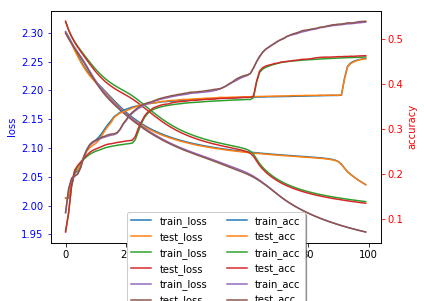

{'train_loss': [2.0365105, 2.0070217, 1.9544357], 'test_loss': [2.0363777, 2.0041754, 1.9542264], 'train_acc': [0.45653334, 0.45983332, 0.53693336], 'test_acc': [0.4558, 0.4627, 0.539], 'p_norm': [18.85863, 18.820093, 18.956707], 'hessian_eigens_mean': [0.0005078837238618771, 0.0004322855603869862, 0.0007181751923438055], 'hessian_eigens_max': [0.65402377, 0.57525146, 1.2136763]}
{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.01, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}


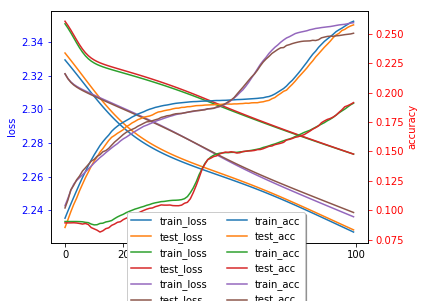

{'train_loss': [2.2270942, 2.2734067, 2.2361825], 'test_loss': [2.2284012, 2.2734156, 2.2387233], 'train_acc': [0.2607, 0.19098334, 0.25945], 'test_acc': [0.2576, 0.1915, 0.2505], 'p_norm': [18.257769, 18.447746, 18.308979], 'hessian_eigens_mean': [0.00042228818195996, 0.0001911339297972246, 0.00037886658956463995], 'hessian_eigens_max': [1.1001838, 0.42927963, 0.87097263]}
{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.001, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}


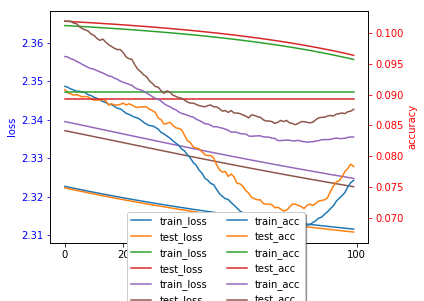

{'train_loss': [2.3116536, 2.3557012, 2.3248215], 'test_loss': [2.310888, 2.3567836, 2.322664], 'train_acc': [0.076066665, 0.09035, 0.0831], 'test_acc': [0.0783, 0.0892, 0.0876], 'p_norm': [18.094687, 18.492222, 18.505205], 'hessian_eigens_mean': [2.5901661508973566e-05, -3.1145937759798444e-05, 3.684622345261124e-05], 'hessian_eigens_max': [0.11710489, 0.036719453, 0.34404552]}
{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}


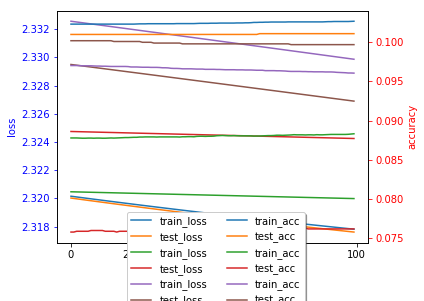

{'train_loss': [2.3178213, 2.3199918, 2.3298686], 'test_loss': [2.3176177, 2.32425, 2.3268998], 'train_acc': [0.102683336, 0.08833333, 0.09606667], 'test_acc': [0.1011, 0.0762, 0.0997], 'p_norm': [18.518845, 18.284273, 18.488733], 'hessian_eigens_mean': [3.967235531551699e-05, 2.9865368104234376e-05, -1.7186745865762078e-05], 'hessian_eigens_max': [0.27759638, 0.23981565, 0.07698404]}
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1, 'ro': -1, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma--1_p-3.0_ro--1_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
None
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1, 'ro': 0.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}
File opti

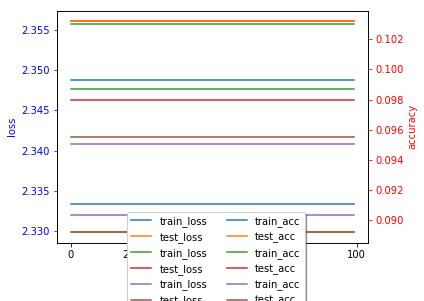

{'train_loss': [2.3334193, 2.3557436, 2.3408098], 'test_loss': [2.3298995, 2.356067, 2.3416493], 'train_acc': [0.09926666, 0.09871667, 0.09035], 'test_acc': [0.1032, 0.098, 0.0892], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [-1.3975230782562474e-05, -1.826687322479789e-05, -9.000732572646615e-06], 'hessian_eigens_max': [0.07295039, 0.029582167, 0.10850464]}
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.0, 'ro': 0.5, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}
File optimizer-frankwolfe_image_side-5_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-3_train_batch_size-1000_R-20.0_gamma-0.0_p-3.0_ro-0.5_learning_rate-None_beta1-None_beta2-None_epsilon-None.output is empty
None
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.0, 'ro': 1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3}
File 

In [439]:
for param in parameters:
    print(param)
    fs = process_file(get_file(**param), True)
    print(fs)

In [418]:
params_to_processed

[{'train_loss': [2.0365105, 2.0070217, 1.9544357],
  'test_loss': [2.0363777, 2.0041754, 1.9542264],
  'train_acc': [0.45653334, 0.45983332, 0.53693336],
  'test_acc': [0.4558, 0.4627, 0.539],
  'p_norm': [18.85863, 18.820093, 18.956707],
  'hessian_eigens_mean': [0.0005078837238618771,
   0.0004322855603869862,
   0.0007181751923438055],
  'hessian_eigens_max': [0.65402377, 0.57525146, 1.2136763]},
 {'train_loss': [2.2270942, 2.2734067, 2.2361825],
  'test_loss': [2.2284012, 2.2734156, 2.2387233],
  'train_acc': [0.2607, 0.19098334, 0.25945],
  'test_acc': [0.2576, 0.1915, 0.2505],
  'p_norm': [18.257769, 18.447746, 18.308979],
  'hessian_eigens_mean': [0.00042228818195996,
   0.0001911339297972246,
   0.00037886658956463995],
  'hessian_eigens_max': [1.1001838, 0.42927963, 0.87097263]},
 {'train_loss': [2.3116536, 2.3557012, 2.3248215],
  'test_loss': [2.310888, 2.3567836, 2.322664],
  'train_acc': [0.076066665, 0.09035, 0.0831],
  'test_acc': [0.0783, 0.0892, 0.0876],
  'p_norm': [1

In [423]:
def selection_metric(summary):
    """ Summary of one element in params_to_processed[], a number
    Using mean test accuracy over runs
    """
    return np.mean(summary['test_acc']) if summary is not None else -1

In [424]:
def param_to_result(param):
    """ Parameter setting to results summary """
    idx = parameters.index(param)
    return params_to_processed[idx]

In [425]:
def select_best(optim):
    """ Select best parameters for an optimizer """
    
    metrics = [selection_metric(param_to_result(p)) for p in param_groups[optim]]
    best_idx = np.argmax(metrics)
    return parameters.index(param_groups[optim][best_idx])

In [427]:
select_best('adam')

20